In [1]:
import os
import sys
import pickle

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense,Input, Reshape, Conv2D, MaxPool2D, UpSampling2D, Flatten

import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
sig_data_file = "./data/png-images.npy"
labels_data_file = "./data/file-names.pkl"

signs = np.load(sig_data_file)
signs = signs.astype(np.float32) / 255.0
signs_file_names = pickle.load(open(labels_data_file, "rb"))

print(signs.shape)
print(len(signs_file_names))

(3471, 40, 120)
3471


In [95]:
signs_file_names[0]

'./data/ICDAR-2011/trainingSet/OfflineSignatures/Dutch/TrainingSet/Offline Forgeries/0205006_04.png'

In [7]:
np.max(signs)

1.0

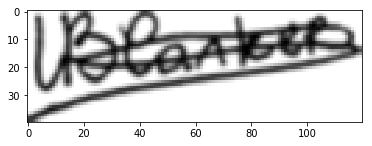

In [8]:
plt.imshow(signs[3], cmap="gray")

In [63]:
def create_autoencoder_model():
    
    tf.keras.backend.clear_session()
    model, encoder, decoder = None, None, None
    
    # Define encoder
    input_img = Input(shape=(40, 120)) 
    x = Reshape((40,120,1))(input_img)
    x = (Conv2D(32, (3,3), activation="relu", padding='same'))(x)
    x = (Conv2D(32, (1,1), activation="relu", padding='same'))(x)
    x = (MaxPool2D(pool_size=(2,2), padding='same'))(x)
    x = (Conv2D(32, (3,3), activation="relu", padding='same'))(x)
    x = (Conv2D(32, (1,1), activation="relu", padding='same'))(x)
    x = (MaxPool2D(pool_size=(2,2), padding='same'))(x)
    x = (Conv2D(16, (3,3), activation="relu", padding='same'))(x)
    x = (MaxPool2D(pool_size=(2,2), padding='same'))(x)
    encoded = (Flatten())(x)
    
    print("Encoder Model")   
    encoder = Model(input_img,encoded)
    encoder.summary()

 
    # Define decoder
    encoded_img = Input(shape=(1200,))
    x = (Reshape((5, 15, 16, )))(encoded_img)
    x = (Conv2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = (UpSampling2D((2, 2)))(x)
    x = (Conv2D(32, (1, 1), activation='relu', padding='same'))(x)
    x = (Conv2D(32, (3, 3), activation="relu", padding='same'))(x)
    x = (UpSampling2D((2, 2)))(x)
    x = (Conv2D(32, (1, 1), activation='relu', padding='same'))(x)
    x = (Conv2D(32, (3, 3), activation="relu", padding='same'))(x)
    x = (UpSampling2D((2, 2)))(x)
    x = (Conv2D(1, (3, 3), activation='sigmoid', padding='same'))(x)
    decoded = Reshape((40,120,))(x)
    
    print("Decoder Model")   
    decoder = Model(encoded_img,decoded)
    decoder.summary()
    
    print("Complete Model")   
    model = Model(input_img, decoder(encoder(input_img)))
    model.compile(optimizer='adam', loss='mse')
    model.summary()
    
    
    return model, encoder, decoder

model, encoder_model, decoder_model = create_autoencoder_model()

Encoder Model
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 40, 120)]         0         
_________________________________________________________________
reshape (Reshape)            (None, 40, 120, 1)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 40, 120, 32)       320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 120, 32)       1056      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 20, 60, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 60, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 60, 32)

In [64]:
x_train = signs
history = model.fit(x=x_train, y=x_train, 
          batch_size=32, epochs=100, 
          verbose=2,
          shuffle=True,
          validation_split=0.1)

Train on 3123 samples, validate on 348 samples
Epoch 1/100
3123/3123 - 2s - loss: 0.0541 - val_loss: 0.0172
Epoch 2/100
3123/3123 - 1s - loss: 0.0452 - val_loss: 0.0172
Epoch 3/100
3123/3123 - 1s - loss: 0.0451 - val_loss: 0.0168
Epoch 4/100
3123/3123 - 1s - loss: 0.0365 - val_loss: 0.0159
Epoch 5/100
3123/3123 - 1s - loss: 0.0301 - val_loss: 0.0099
Epoch 6/100
3123/3123 - 1s - loss: 0.0194 - val_loss: 0.0081
Epoch 7/100
3123/3123 - 1s - loss: 0.0161 - val_loss: 0.0068
Epoch 8/100
3123/3123 - 1s - loss: 0.0143 - val_loss: 0.0058
Epoch 9/100
3123/3123 - 1s - loss: 0.0134 - val_loss: 0.0055
Epoch 10/100
3123/3123 - 1s - loss: 0.0121 - val_loss: 0.0052
Epoch 11/100
3123/3123 - 1s - loss: 0.0113 - val_loss: 0.0049
Epoch 12/100
3123/3123 - 1s - loss: 0.0109 - val_loss: 0.0046
Epoch 13/100
3123/3123 - 1s - loss: 0.0102 - val_loss: 0.0043
Epoch 14/100
3123/3123 - 1s - loss: 0.0098 - val_loss: 0.0046
Epoch 15/100
3123/3123 - 1s - loss: 0.0093 - val_loss: 0.0040
Epoch 16/100
3123/3123 - 1s - lo

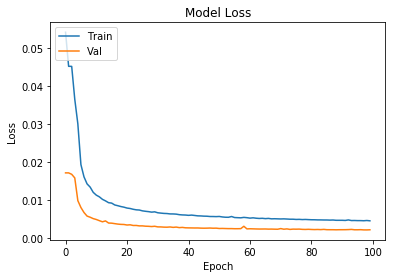

In [65]:
# Plot training & validation accuracy values
def plot_keras_history(h):
    plt.plot(h.history['loss'])
    plt.plot(h.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

plot_keras_history(history)

In [66]:
def show_result(data):
    n = len(data)
    assert n <= 5
    
    fig, axs = plt.subplots(3, n, sharex=True, sharey=True, squeeze=False, figsize=(20,10))
    
    fig.suptitle("Autoencoder Evaluation")
    
    for i,img in enumerate(data):
        # Show origial image
        p = axs[0,i]
        p.imshow(img.reshape((40,120)), cmap="gray")
        p.title.set_text("Original")
        
        encoded = encoder_model.predict(img.reshape((1,40,120))) 
        # Show encoded image
        p2 = axs[1,i]
        p2.imshow(encoded.reshape((30,40)), cmap="gray")
        p2.title.set_text("Encoded")
        
        decoded = decoder_model.predict(encoded) 
        # Show encoded image
        p2 = axs[2,i]
        p2.imshow(decoded.reshape((40,120)), cmap="gray")
        p2.title.set_text("Decoded")
        

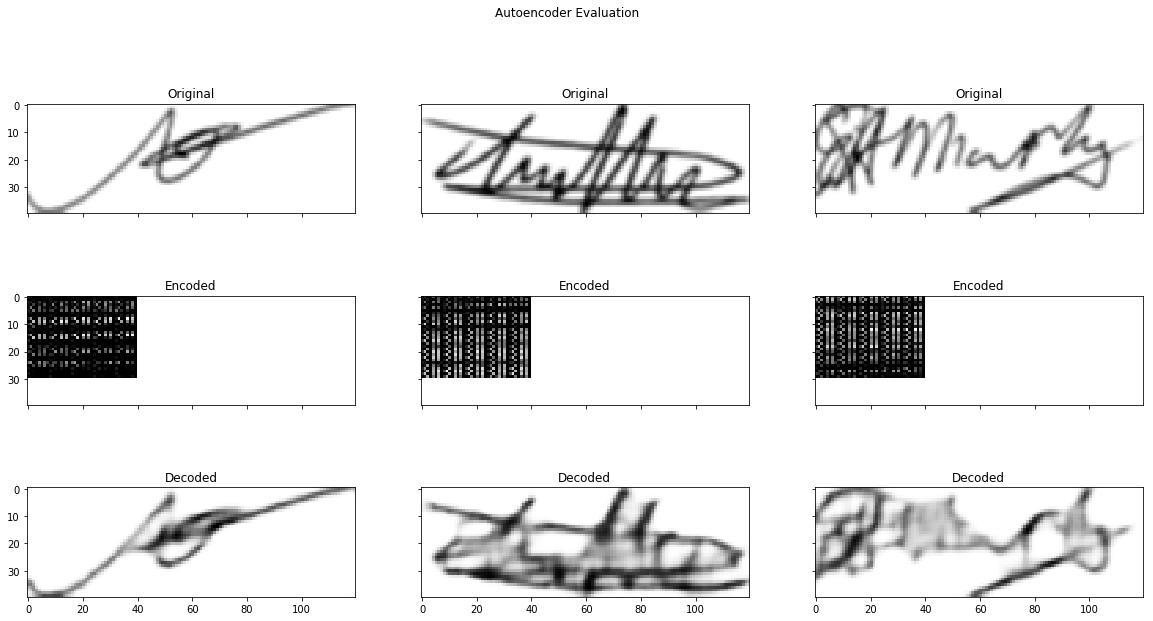

In [70]:
indices = np.random.choice(np.arange(len(x_train)), 3)
show_result(x_train[indices])

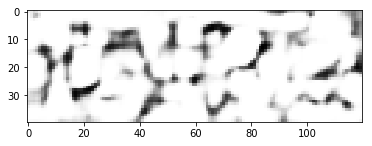

In [68]:
random_data = np.random.random(size=(1,1200))
decoded = decoder_model.predict(random_data)
plt.imshow(decoded.reshape(40,120), cmap="gray")

In [73]:
model.save("./data/model_store/model_1/complete-auto-encoder-model.h5")
encoder_model.save("./data/model_store/model_1/encoder-model.h5")
encoder_model.save_weights("./data/model_store/model_1/encoder-model-weights.h5")
decoder_model.save("./data/model_store/model_1/decoder-model.h5")
decoder_model.save_weights("./data/model_store/model_1/decoder-model-weights.h5")

In [74]:
print("done")

done


In [82]:
from bulk_image_reader import read_and_preprocess_image
from sklearn.metrics.pairwise import cosine_similarity

In [87]:
original = "./data/ICDAR-2011/trainingSet/OfflineSignatures/Dutch/TrainingSet/Offline Genuine/001_01.PNG"
genuine_copy = "./data/ICDAR-2011/trainingSet/OfflineSignatures/Dutch/TrainingSet/Offline Genuine/001_02.PNG"
forge_copy = "./data/ICDAR-2011/trainingSet/OfflineSignatures/Dutch/TrainingSet/Offline Forgeries/0119001_01.png"

img_or = read_and_preprocess_image(original).astype(np.float32) / 255.0
img_g = read_and_preprocess_image(genuine_copy).astype(np.float32) / 255.0
img_f = read_and_preprocess_image(forge_copy).astype(np.float32) / 255.0

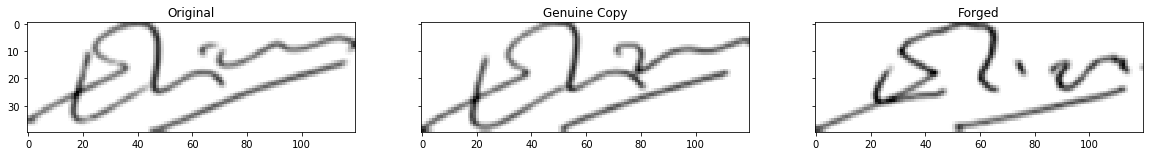

In [88]:
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, squeeze=False, figsize=(20,10))
p1 = axs[0,0]
p1.imshow(img_or.reshape((40,120)), cmap="gray")
p1.title.set_text("Original")
p2 = axs[0,1]
p2.imshow(img_g.reshape((40,120)), cmap="gray")
p2.title.set_text("Genuine Copy")
p3 = axs[0,2]
p3.imshow(img_f.reshape((40,120)), cmap="gray")
p3.title.set_text("Forged")

In [89]:
img_or_vec = encoder_model.predict(img_or.reshape((1,40,120))) 
img_g_vec = encoder_model.predict(img_g.reshape((1,40,120))) 
img_f_vec = encoder_model.predict(img_f.reshape((1,40,120))) 

In [90]:
img_or_vec.shape

(1, 1200)

In [91]:
print(cosine_similarity(img_or_vec,img_g_vec))

[[0.89627874]]


In [92]:
print(cosine_similarity(img_or_vec,img_f_vec))

[[0.80716175]]


In [93]:
other_person_signature = "./data/ICDAR-2011/trainingSet/OfflineSignatures/Dutch/TrainingSet/Offline Genuine/004_20.PNG"
other_img = read_and_preprocess_image(other_person_signature).astype(np.float32) / 255.0 
other_img_vec = encoder_model.predict(other_img.reshape((1,40,120)))
print(cosine_similarity(img_or_vec,other_img_vec))

[[0.75108045]]


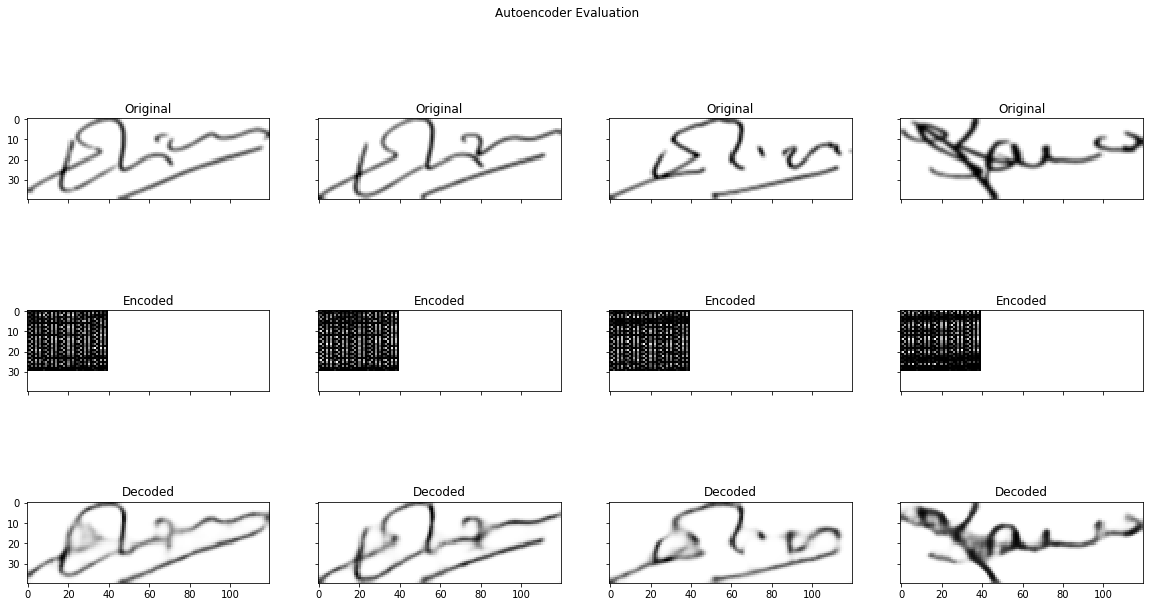

In [94]:
show_result([img_or, img_g, img_f, other_img])